Imports and conversion factors:

In [1]:
# Import OpenMC library for simulation
import openmc

# Import NumPy for numerical operations
import numpy as np

# Import matplotlib for plotting (optional)
import matplotlib.pyplot as plt

import h5py

# Conversion factors
inch_to_cm = 2.54  # 1 inch = 2.54 cm


Materials: Create materials.xml file

In [2]:
########################   Materials #######################################

# Create a Materials collection
materials = openmc.Materials()

In [3]:
# 1. Deuterium Gas
# ----------------
# Deuterium gas at low pressure due to high vacuum
# We'll assume a low density for the deuterium gas

# 1. Deuterium Gas
deuterium = openmc.Material(name='Deuterium Gas')
deuterium.add_nuclide('H2', 1.0, percent_type='ao')
deuterium.set_density('g/cm3', 1e-6)
materials.append(deuterium)

In [4]:
# 2. 504 Stainless Steel
# ----------------------
# Composition based on typical 504 stainless steel

# Stainless Steel (approximate composition for 504 stainless steel)
steel = openmc.Material(name='Stainless Steel')
steel.add_element('Fe', 0.70)
steel.add_element('Cr', 0.18)
steel.add_element('Ni', 0.12)
steel.set_density('g/cm3', 8.0)
materials.append(stainless_steel)

In [5]:
# 3. Tungsten
# -----------
# Used for the inner grid

tungsten = openmc.Material(name='Tungsten')
tungsten.add_element('W', 1.0)
tungsten.set_density('g/cm3', 19.25)
materials.append(tungsten)

In [6]:
# 4.A Inner Grid Material (Volume-Averaged)
#----------------------------------------

# Calculations:
# Wire parameters
number_of_wires = 3
wire_diameter = 0.25  # cm (assumed value)
wire_radius = wire_diameter / 2

# Inner grid diameter and radius
inner_diameter_in = 2.0  # inches
inner_diameter_cm = inner_diameter_in * inch_to_cm
inner_radius_cm = inner_diameter_cm / 2

# Length of each wire (circumference of circle)
wire_length = np.pi * inner_diameter_cm  # cm

# Cross-sectional area of the wire
cross_sectional_area = np.pi * wire_radius**2  # cm^2

# Volume of one wire
volume_wire = wire_length * cross_sectional_area  # cm^3

# Total volume of wires
volume_wires = number_of_wires * volume_wire  # cm^3

# Volume of inner grid shell (approximate as thin shell)
delta_r = wire_diameter  # cm (thickness of inner grid shell)
volume_inner_grid_shell = 4 * np.pi * inner_radius_cm**2 * delta_r  # cm^3

# Volume fraction of tungsten in the inner grid shell
volume_fraction_W = volume_wires / volume_inner_grid_shell

print(f"Volume of wires: {volume_wires:.5e} cm^3")
print(f"Volume of inner grid shell: {volume_inner_grid_shell:.5e} cm^3")
print(f"Volume fraction of tungsten: {volume_fraction_W:.5e}")

Volume of wires: 2.35020e+00 cm^3
Volume of inner grid shell: 2.02683e+01 cm^3
Volume fraction of tungsten: 1.15954e-01


In [7]:
# 4.B Add the inner grid average material to xml
#----------------------------------------------

# Compute the density of the inner grid material
density_W = 19.25  # g/cm3 for tungsten
density_deuterium = deuterium.density  # Should be 1e-10 g/cm3

# Compute density of inner grid material (negligible contribution from deuterium)
density_inner_grid_material = volume_fraction_W * density_W

# Create a new material for the inner grid region
inner_grid_material = openmc.Material(name='Inner Grid Material')
inner_grid_material.add_element('W', 1.0)
inner_grid_material.set_density('g/cm3', density_inner_grid_material)
materials.append(inner_grid_material)


In [8]:
# 5. Materials for detectors
# ------------------

# Create materials for the detector regions (use a minimal gas)
void_material = openmc.Material(name='Void Material')
void_material.add_nuclide('H1', 1.0)  # Add a nuclide 
void_material.set_density('g/cm3', 1e-10)  # Replace with 1e-10

# Add the void material to the existing materials collection
materials.append(void_material)

In [9]:
# 5. Material for Air
# --------------------

# Create material for air
air = openmc.Material(name='Air')
air.add_element('N', 0.78084)
air.add_element('O', 0.20946)
air.add_element('Ar', 0.00934)
air.add_element('C', 0.00036)
air.set_density('g/cm3', 0.0012)  # Density of air at sea level in g/cm3

# Add the air material to the materials collection
materials.append(air)


In [10]:
#5. Export materials to XML
#---------------------

materials.export_to_xml()

Geometry: Define geometry and export to xml

In [11]:
# 1. Outer Shell
# --------------
# Diameter: 8 inches
outer_diameter_in = 8.0
outer_diameter_cm = outer_diameter_in * inch_to_cm  # Convert to cm
outer_radius_cm = outer_diameter_cm / 2

# Thickness: 1/8 inch
shell_thickness_in = 0.125
shell_thickness_cm = shell_thickness_in * inch_to_cm

# Inner radius of the outer shell
outer_shell_inner_radius = outer_radius_cm - shell_thickness_cm

# Define outer shell surfaces

# Thickness of the detector shell
detector_thickness = 0.1  # cm
distance_operator_cm = 6 * 12 * inch_to_cm  # 6 feet to cm

# Outer surface of the outer shell (boundary of the geometry)
outer_shell_outer_surface = openmc.Sphere(r=outer_radius_cm)

# Inner surface of the outer shell
outer_shell_inner_surface = openmc.Sphere(r=outer_shell_inner_radius)

# New outer boundary radius (ensure it includes the operator location)
new_outer_boundary_radius = distance_operator_cm + 500  # Add some margin (e.g., 10 cm)

# Define the new outer boundary surface
outer_boundary_surface = openmc.Sphere(r=new_outer_boundary_radius,  boundary_type = "vacuum")

# Surface right outside the reactor (just beyond outer radius)
detector_outer_surface = openmc.Sphere(r=outer_radius_cm + detector_thickness)

# Surfaces at operator location
surface_operator_inner = openmc.Sphere(r=distance_operator_cm - detector_thickness / 2)
surface_operator_outer = openmc.Sphere(r=distance_operator_cm + detector_thickness / 2)

In [12]:
# 2. Inner Grid
# -------------
# Inner grid radius is inner_radius_cm (already defined)

# Small thickness for the inner grid shell
delta_r = 0.001  # cm

# Inner and outer surfaces of the inner grid shell
inner_grid_shell_inner_surface = openmc.Sphere(r=inner_radius_cm - delta_r/2)
inner_grid_shell_outer_surface = openmc.Sphere(r=inner_radius_cm + delta_r/2)

In [13]:
# 3. Regions
# ----------
# Core region (inside inner grid shell)
core_region = -inner_grid_shell_inner_surface

# Inner grid shell region
inner_grid_shell_region = +inner_grid_shell_inner_surface & -inner_grid_shell_outer_surface

# Gas region (between inner grid shell and outer shell inner surface)
gas_region = +inner_grid_shell_outer_surface & -outer_shell_inner_surface

# Outer shell region
outer_shell_region = +outer_shell_inner_surface & -outer_shell_outer_surface

# Region right outside the reactor
region_outer_detector = +outer_shell_outer_surface & -detector_outer_surface

# Define the outside region (fill with void material)
outside_region = +detector_outer_surface & -surface_operator_inner

# Region at operator location
region_operator_detector = +surface_operator_inner & -surface_operator_outer

# Final outer region
outermost_region = +surface_operator_outer & -outer_boundary_surface

In [14]:
# 4. Cells
# --------

# Core plasma cell
core_cell = openmc.Cell(name='Core Plasma', fill=deuterium, region=core_region)

# Inner grid shell cell
inner_grid_cell = openmc.Cell(name='Inner Grid Shell', fill=inner_grid_material, region=inner_grid_shell_region)

# Gas cell
gas_cell = openmc.Cell(name='Deuterium Gas', fill=deuterium, region=gas_region)

# Outer shell cell
outer_shell_cell = openmc.Cell(name='Outer Shell', fill=stainless_steel, region=outer_shell_region)

# Create a cell for the outside region filled with void material
outside_cell = openmc.Cell(name='Outside Region', fill=air, region=outside_region)

# Outer detector cell
outer_detector_cell = openmc.Cell(name='Outer Detector', fill=void_material, region=region_outer_detector)

# Operator detector cell
operator_detector_cell = openmc.Cell(name='Operator Detector', fill=void_material, region=region_operator_detector)

# Outermost region cell
outermost_region_cell =  openmc.Cell(name='Outermost Region', fill=air, region=outermost_region)

In [15]:
# 5. Universe and Geometry
# ------------------------
universe = openmc.Universe(cells=[core_cell, inner_grid_cell, gas_cell, outer_shell_cell, outside_cell, outer_detector_cell, operator_detector_cell, outermost_region_cell])
geometry = openmc.Geometry(universe)
geometry.export_to_xml()

Source: Define the neutron source

In [16]:
# 1. Define the Neutron Source
# ----------------------------

# Neutron energy from D-D fusion (~2.45 MeV)
neutron_energy = 2.45e6  # eV

# Radial distribution: Uniform from 0 to inner radius minus half the grid thickness
radius_distribution = openmc.stats.Uniform(0.0, inner_radius_cm - delta_r/2)

# Cosine of the polar angle distribution: Uniform from -1 to 1
cos_theta_distribution = openmc.stats.Uniform(-1.0, 1.0)

# Azimuthal angle distribution: Uniform from 0 to 2*pi
phi_distribution = openmc.stats.Uniform(0.0, 2 * np.pi)

# Create the SphericalIndependent spatial distribution
source_space = openmc.stats.SphericalIndependent(
    r=radius_distribution,
    cos_theta=cos_theta_distribution,
    phi=phi_distribution
)

# Energy distribution: Monoenergetic at 2.45 MeV
source_energy = openmc.stats.Discrete([neutron_energy], [1.0])

# Angular distribution: Isotropic
source_angle = openmc.stats.Isotropic()

# Create the neutron source
source = openmc.Source(
    space=source_space,
    energy=source_energy,
    angle=source_angle,
    particle='neutron'
)


/opt/venv/lib/python3.11/site-packages/openmc/source.py:656: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


Simulation settings: create settings.xml file

In [17]:
# 1. Simulation Settings
# ----------------------

settings = openmc.Settings()
settings.run_mode = 'fixed source'  # Fixed source simulation
settings.particles = 100000          # Number of particles per batch
settings.batches = 100              # Total number of batches
settings.inactive = 50
settings.source = source            # Set the source
settings.photon_transport = True   # Enable if interested in photons
# settings.seed = 12345              # For reproducibility (optional)

settings.export_to_xml()


Define tallies:

In [18]:
tallies = openmc.Tallies()

In [19]:
# 1. Create a Mesh Tally for Neutron Flux
# ---------------------------------------

# Define a mesh over the geometry
mesh = openmc.RegularMesh()
mesh.dimension = [100, 100, 100] 
mesh.lower_left = [-new_outer_boundary_radius, -new_outer_boundary_radius, -new_outer_boundary_radius]
mesh.upper_right = [new_outer_boundary_radius, new_outer_boundary_radius, new_outer_boundary_radius]


# Create mesh filter
mesh_filter = openmc.MeshFilter(mesh)

In [20]:
# 2. Define the Flux Tally
# ------------------------

flux_tally = openmc.Tally(name='Neutron Flux')
flux_tally.filters = [mesh_filter]
flux_tally.scores = ['flux']

tallies.append(flux_tally)

# Define a cell filter for the core region
core_cell_filter = openmc.CellFilter(core_cell)

# Tally for neutron flux in the core region
core_flux_tally = openmc.Tally(name='Core Neutron Flux')
core_flux_tally.filters = [core_cell_filter]
core_flux_tally.scores = ['flux']

# Add the tally to the tallies collection
tallies.append(core_flux_tally)


In [21]:
# 3. Tritium Production Tally
# ---------------------------

# Define the reactions leading to tritium production
# Assuming tritium production via neutron capture on deuterium (MT=105)
# Note: MT=105 corresponds to (n,t) reactions

tritium_tally = openmc.Tally(name='Tritium Production')
tritium_tally.filters = [mesh_filter]
tritium_tally.scores = ['(n,t)']

tallies.append(tritium_tally)

In [22]:

############################ Define Flux Tallies ####################

# Create cell filters for the detector regions
outer_detector_filter = openmc.CellFilter(outer_detector_cell)
operator_detector_filter = openmc.CellFilter(operator_detector_cell)

# Tally for neutron flux right outside the reactor
outer_flux_tally = openmc.Tally(name='Outer Flux')
outer_flux_tally.filters = [outer_detector_filter]
outer_flux_tally.scores = ['flux']

# Tally for neutron flux at operator location
operator_flux_tally = openmc.Tally(name='Operator Flux')
operator_flux_tally.filters = [operator_detector_filter]
operator_flux_tally.scores = ['flux']

# If you have an existing tallies collection, append to it
# Remove 'tallies = openmc.Tallies()' to avoid overwriting
tallies.append(outer_flux_tally)
tallies.append(operator_flux_tally)
tallies.export_to_xml()

In [23]:
# 5. Tallies Collection
# ---------------------

tallies.export_to_xml()

Run the simulation:

In [24]:
# Run OpenMC simulation
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

Analyze the results:

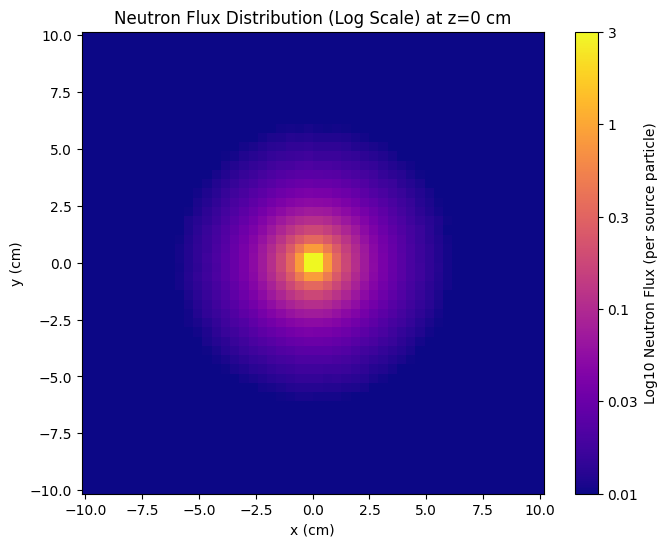

In [29]:
# Load the statepoint file
sp = openmc.StatePoint('statepoint.100.h5')

# Access the flux tally
flux_tally_result = sp.get_tally(name='Neutron Flux')

# Extract the flux data
flux_data = flux_tally_result.get_slice(scores=['flux']).mean

# Reshape the flux data to a 3D array for plotting
flux_data.shape = mesh.dimension

# Plot the neutron flux distribution at z=0 cm
z_index = mesh.dimension[2] // 2  # Index for z=0 plane

# Create the plot
plt.figure(figsize=(8, 6))

# Use a logarithmic color scale for better detail in lower flux regions
flux_data_log = np.log10(np.maximum(flux_data[:, :, z_index], 1e-10))  # Avoid log(0)

# Adjust the colormap limits to focus on the range of interest (e.g., -2 to 0.5 in log scale)
vmin, vmax = -2, 0.5  # These limits can be adjusted for more or less detail

plt.imshow(flux_data_log,
           extent=[-outer_radius_cm, outer_radius_cm, -outer_radius_cm, outer_radius_cm],
           origin='lower',
           cmap='plasma',  # Use a colormap with more distinct colors (e.g., plasma)
           vmin=vmin,
           vmax=vmax)

# Add color bar with adjusted scale
cbar = plt.colorbar(label='Log10 Neutron Flux (per source particle)')
cbar.set_ticks([-2, -1.5, -1, -0.5, 0, 0.5])  # Adjust ticks for finer detail
cbar.set_ticklabels(['0.01', '0.03', '0.1', '0.3', '1', '3'])  # Convert log values to human-readable scale

plt.title('Neutron Flux Distribution (Log Scale) at z=0 cm')
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.show()

In [26]:
# Load the statepoint file (adjust the filename if necessary)
sp = openmc.StatePoint('statepoint.100.h5')

# Access the tallies
outer_flux_tally_result = sp.get_tally(name='Outer Flux')
operator_flux_tally_result = sp.get_tally(name='Operator Flux')

# Get the mean neutron flux values
outer_flux = outer_flux_tally_result.mean.flatten()[0]
outer_flux_uncertainty = outer_flux_tally_result.std_dev.flatten()[0]

operator_flux = operator_flux_tally_result.mean.flatten()[0]
operator_flux_uncertainty = operator_flux_tally_result.std_dev.flatten()[0]

print(f"Neutron flux right outside the reactor: {outer_flux:.6e} +/- {outer_flux_uncertainty:.6e} per source neutron")
print(f"Neutron flux at operator location (6 feet away): {operator_flux:.6e} +/- {operator_flux_uncertainty:.6e} per source neutron")


Neutron flux right outside the reactor: 1.162254e-01 +/- 2.425567e-05 per source neutron
Neutron flux at operator location (6 feet away): 1.042992e-01 +/- 1.434801e-05 per source neutron
